In [415]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [416]:
general_name = 'debug' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_reals.npy']

In [417]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

In [418]:
reals.shape

(119, 1, 32, 32)

# Error of ASPA $i$

In [419]:
i = 0

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000
mean,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654
25%,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654
50%,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654
75%,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654
max,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654


In [420]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-7.866688,-6.208504,-7.098838,-5.372151,3.723709e+27,8.808186e+07,1756.163836,-0.000514,22.518654


In [421]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [422]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(119, 1, 32, 32)

# Error all ASPAs

In [423]:
reals[0].shape

(1, 32, 32)

## Spectrum plot

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:370: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:371: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


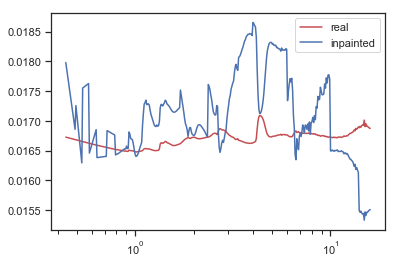

In [424]:
i = 0

xhat,yhat = ke.decode_spectrum_from_aspa(reals[i][0])
x,y  = ke.decode_spectrum_from_aspa(inpainteds[i][0])

plt.plot(xhat, yhat, label='real', c='r')
plt.plot(x,y,label='inpainted')

plt.gca().set_xscale('log')

plt.legend()

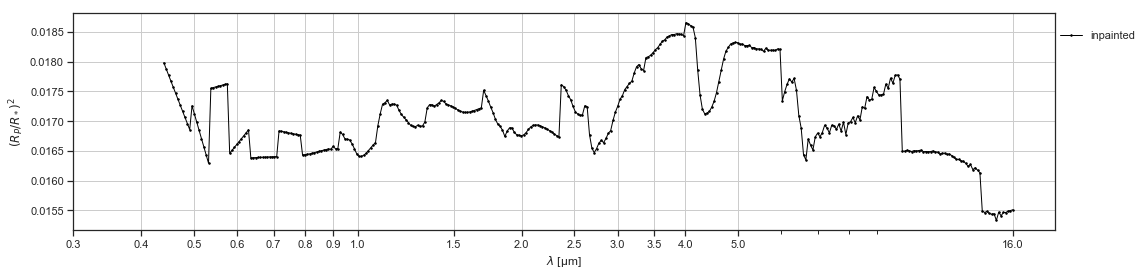

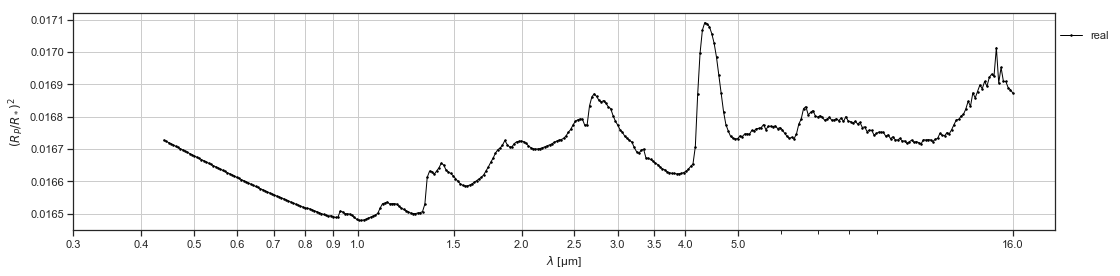

In [425]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

In [426]:
reals.shape

(119, 1, 32, 32)

In [427]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [428]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [429]:
contextuals.shape

(119,)

In [430]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [431]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,-1.806607,-4.683498,19.178160,4.543280,8.425110,-0.867481,4.866651
std,38.549219,56.735170,114.393806,59.094415,43.900754,2.145662,31.536133
min,-78.353716,-78.792159,-86.504053,-79.419381,-60.968938,-12.373239,-50.821888
25%,-11.820821,-15.724878,-28.283490,-10.318407,-21.474179,-1.885027,-21.927558
50%,-2.807436,-4.007810,-4.038684,-5.038846,-0.788555,-0.725351,2.681721
75%,0.086137,0.378767,21.365743,4.455042,26.471436,0.541539,24.460874
max,204.650284,519.285876,740.977824,527.653933,133.529833,2.936640,97.177392


In [432]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,-1.666403,-3.661147,10.154382,-5.197329,110.204865,-0.533097,75.616384
1,-2.492086,-12.026938,-33.253849,56.615334,-12.174980,-2.757346,-2.604043
2,8.181972,9.887878,38.305797,54.833658,-28.120594,0.351547,22.726097
3,29.262420,-8.343071,-60.249940,-36.255731,64.931536,-2.695629,-6.293899
4,-12.147767,-41.125517,-20.595139,-20.606716,-34.260987,0.518262,-4.936674
5,-9.152788,-3.883806,51.269531,-11.054539,-24.959084,-0.762882,-28.477820
6,5.661854,-1.646023,11.392425,-5.841619,-8.051401,-0.508566,29.186715
7,-11.207374,-25.618345,-10.293262,50.844180,53.071665,-0.737735,-24.640538
8,-7.116568,3.109697,22.371337,-4.949025,11.858168,0.845266,35.754747
9,142.175359,36.797206,-12.387649,-6.512452,97.617791,0.762739,29.264649


In [433]:
errors[errors.planet_radius_error < -50]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error


In [434]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [435]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,119.000000,119.000000,119.000000,119.000000,1.190000e+02,1.190000e+02,119.000000,119.000000,119.000000,119.000000,...,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,1.190000e+02,119.000000
mean,-4.320261,-4.372549,-4.777778,-4.228758,2.662517e+27,7.987218e+07,1565.826332,-4.040655,-4.102200,-4.620451,...,1567.903870,-1.806607,-4.683498,19.178160,4.543280,8.425110,-0.867481,4.866651,-7.492025e-04,25.360641
std,2.254436,2.273863,2.262581,2.254302,7.490153e+26,1.470194e+07,327.951408,2.295385,2.514506,2.314673,...,321.995945,38.549219,56.735170,114.393806,59.094415,43.900754,2.145662,31.536133,4.433433e-04,24.463846
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-8.330245,-8.553615,-9.577977,...,944.770038,-78.353716,-78.792159,-86.504053,-79.419381,-60.968938,-12.373239,-50.821888,-1.792097e-03,9.693842
25%,-6.444445,-6.444445,-6.444445,-5.666667,2.024533e+27,6.680384e+07,1333.333328,-5.664749,-6.273435,-6.454406,...,1270.873912,-11.820821,-15.724878,-28.283490,-10.318407,-21.474179,-1.885027,-21.927558,-1.042429e-03,12.725346
50%,-4.111111,-4.888889,-4.888889,-4.111111,2.530667e+27,7.767889e+07,1555.555556,-3.765465,-4.043441,-4.743908,...,1644.312203,-2.807436,-4.007810,-4.038684,-5.038846,-0.788555,-0.725351,2.681721,-7.902985e-04,15.617172
75%,-2.166667,-2.166667,-2.555555,-1.777778,3.289867e+27,9.399146e+07,1888.888896,-1.816100,-1.695999,-2.810791,...,1833.756357,0.086137,0.378767,21.365743,4.455042,26.471436,0.541539,24.460874,-4.253904e-04,22.996580
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-0.873253,-0.798005,-0.667462,...,2171.658158,204.650284,519.285876,740.977824,527.653933,133.529833,2.936640,97.177392,-2.283119e-07,127.203217


In [436]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-8.000000,-6.444445,-6.444445,-5.666667,1.771467e+27,8.855393e+07,1000.000000,-7.866688,-6.208504,-7.098838,...,1756.163836,-1.666403,-3.661147,10.154382,-5.197329,110.204865,-0.533097,75.616384,-0.000514,22.518654
1,-4.111111,-5.666667,-1.000000,-4.111111,3.036800e+27,6.136632e+07,2000.000000,-4.008659,-4.985140,-0.667462,...,1947.919130,-2.492086,-12.026938,-33.253849,56.615334,-12.174980,-2.757346,-2.604043,-0.000941,68.001099
2,-2.555555,-2.555555,-4.888889,-4.888889,1.771467e+27,9.942898e+07,1666.666672,-2.764650,-2.808246,-6.761617,...,2045.434952,8.181972,9.887878,38.305797,54.833658,-28.120594,0.351547,22.726097,-0.000731,14.728926
3,-6.444445,-6.444445,-8.000000,-2.555555,1.518400e+27,8.855393e+07,1777.777791,-8.330245,-5.906780,-3.180005,...,1665.886253,29.262420,-8.343071,-60.249940,-36.255731,64.931536,-2.695629,-6.293899,-0.000076,28.055511
4,-4.111111,-1.777778,-1.000000,-2.555555,3.542933e+27,7.224137e+07,1777.777791,-3.611703,-1.046657,-0.794049,...,1690.014705,-12.147767,-41.125517,-20.595139,-20.606716,-34.260987,0.518262,-4.936674,-0.000418,20.239948
5,-1.000000,-7.222222,-4.111111,-8.000000,3.542933e+27,6.680384e+07,1555.555556,-0.908472,-6.941725,-6.218858,...,1112.567246,-9.152788,-3.883806,51.269531,-11.054539,-24.959084,-0.762882,-28.477820,-0.001036,11.677099
6,-7.222222,-4.111111,-7.222222,-3.333333,1.518400e+27,8.855393e+07,1222.222209,-7.631134,-4.043441,-8.045009,...,1578.948721,5.661854,-1.646023,11.392425,-5.841619,-8.051401,-0.508566,29.186715,-0.001149,12.414839
7,-4.888889,-2.555555,-8.000000,-4.888889,2.277600e+27,8.855393e+07,1888.888896,-4.340973,-1.900864,-7.176539,...,1423.456505,-11.207374,-25.618345,-10.293262,50.844180,53.071665,-0.737735,-24.640538,-0.000583,57.482330
8,-1.000000,-8.000000,-3.333333,-4.111111,3.036800e+27,7.767889e+07,1111.111104,-0.928834,-8.248776,-4.079045,...,1508.386063,-7.116568,3.109697,22.371337,-4.949025,11.858168,0.845266,35.754747,-0.000914,11.657088
9,-1.000000,-4.111111,-6.444445,-8.000000,1.771467e+27,7.767889e+07,1555.555556,-2.421754,-5.623885,-5.646129,...,2010.783434,142.175359,36.797206,-12.387649,-6.512452,97.617791,0.762739,29.264649,-0.000433,14.171713


In [437]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

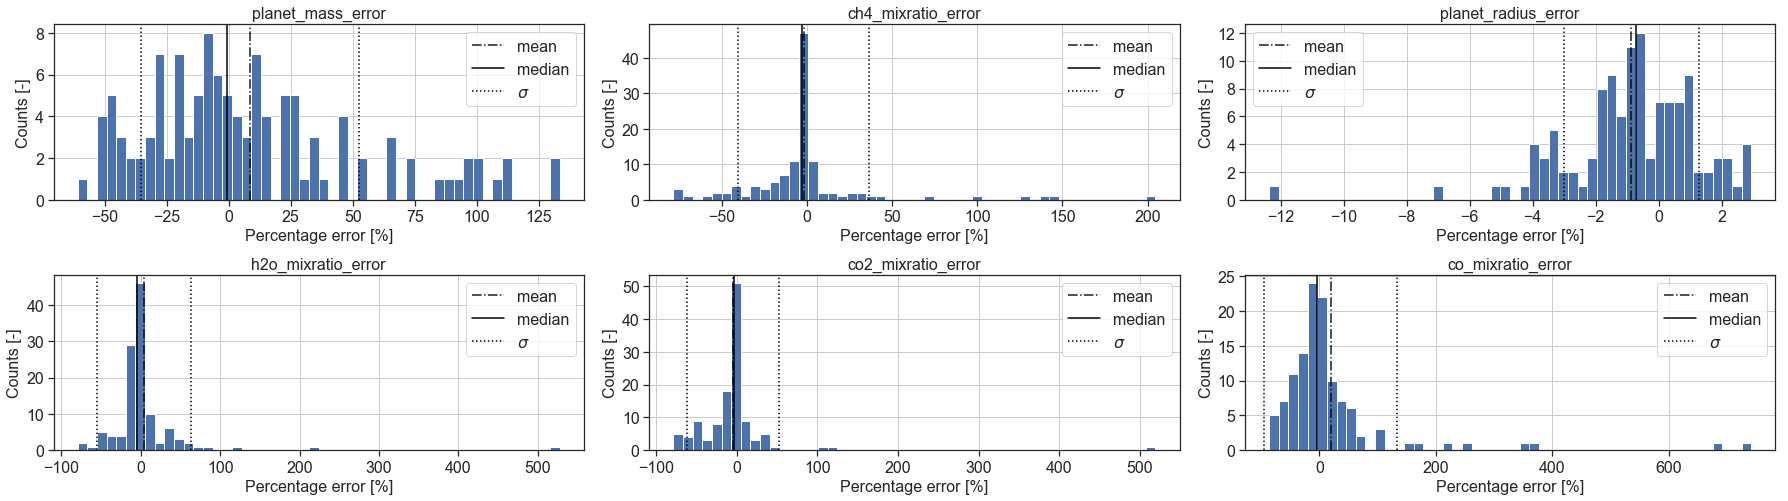

In [438]:
#params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

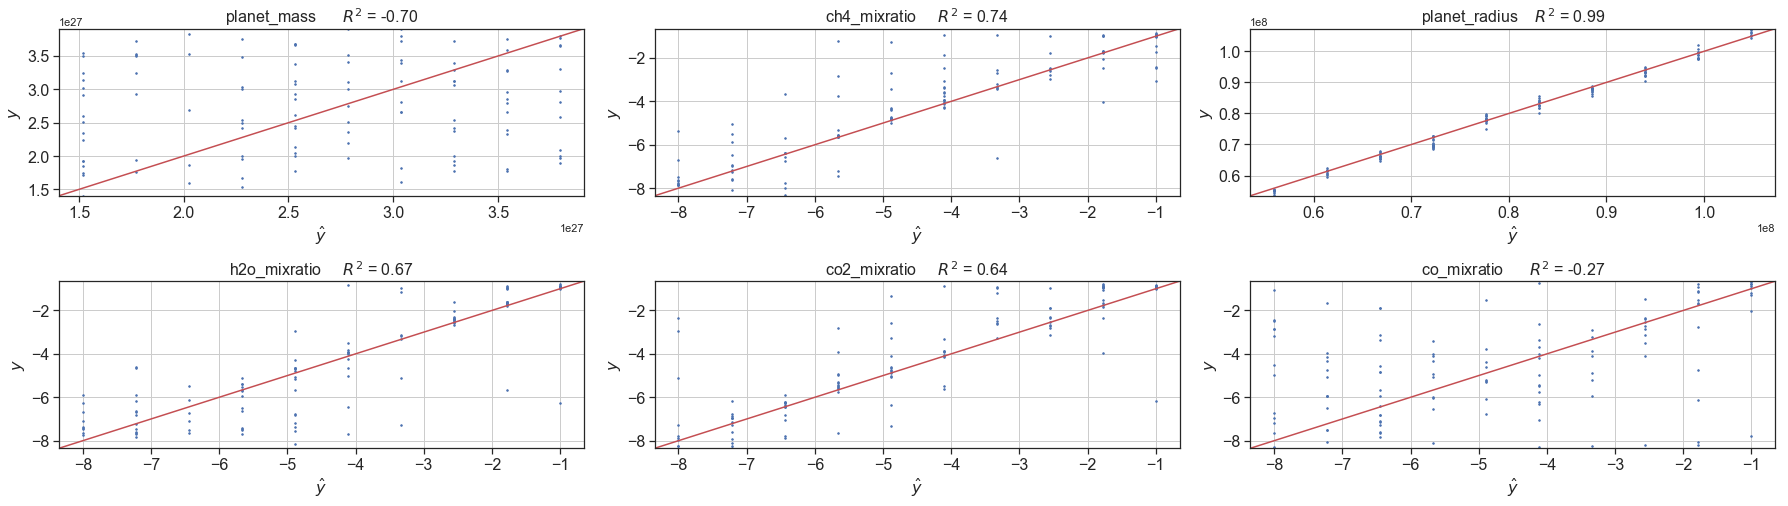

In [439]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

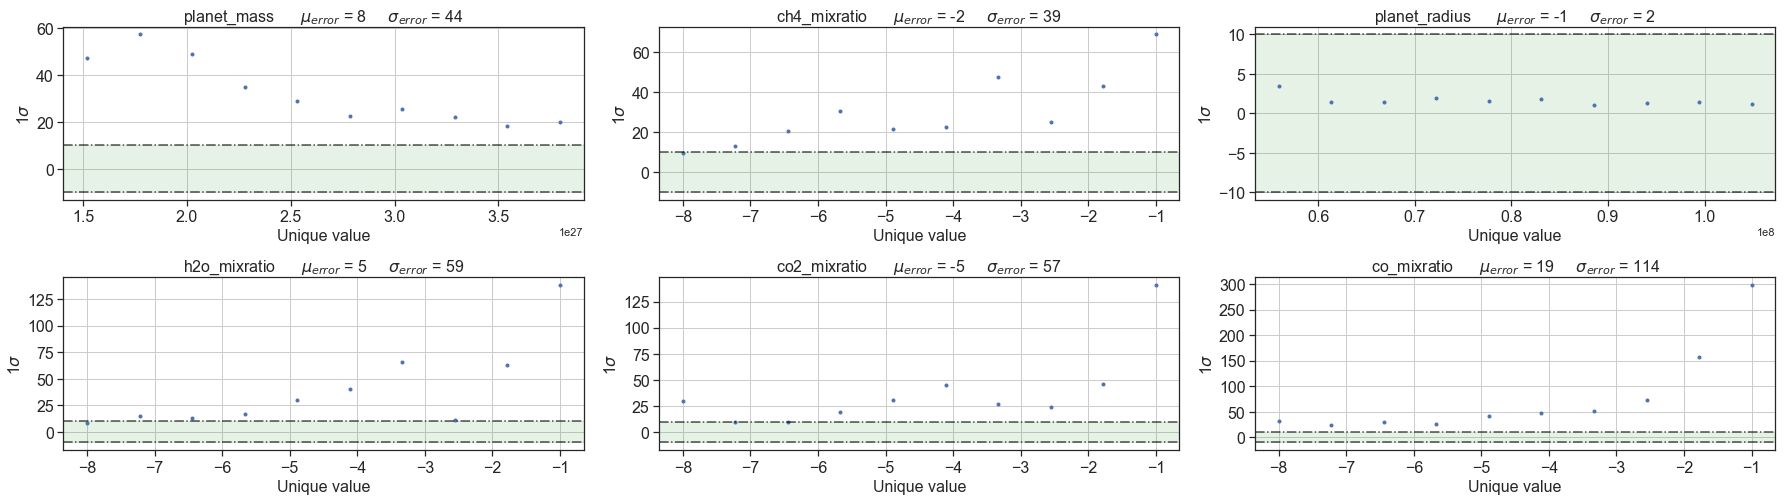

In [440]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f     $\sigma_{error}$ = %.0f' % (param, df[param+'_error'].mean(), df[param+'_error'].std())
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [441]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [442]:
uniques

array([-6.44444454, -1.        , -4.88888889, -8.        , -4.11111111,
       -7.22222227, -3.3333333 , -2.55555546, -5.6666667 , -1.77777773])

# Losses

In [443]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,1.190000e+02,119.000000
mean,-7.492025e-04,25.360641
std,4.433433e-04,24.463846
min,-1.792097e-03,9.693842
25%,-1.042429e-03,12.725346
50%,-7.902985e-04,15.617172
75%,-4.253904e-04,22.996580
max,-2.283119e-07,127.203217


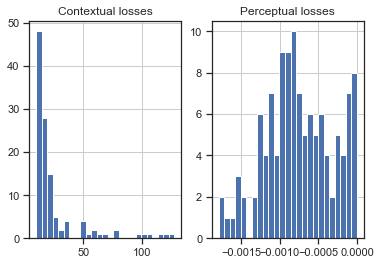

In [444]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

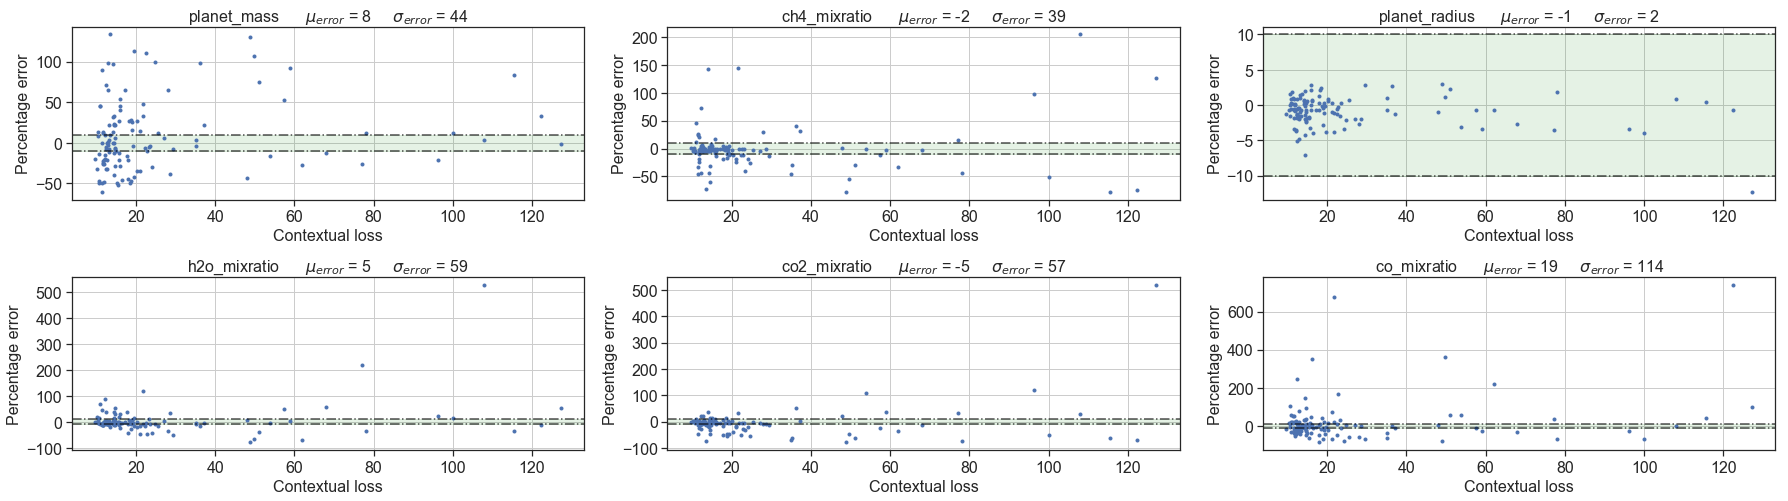

In [445]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f     $\sigma_{error}$ = %.0f' % (param, df[param+'_error'].mean(), df[param+'_error'].std())
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

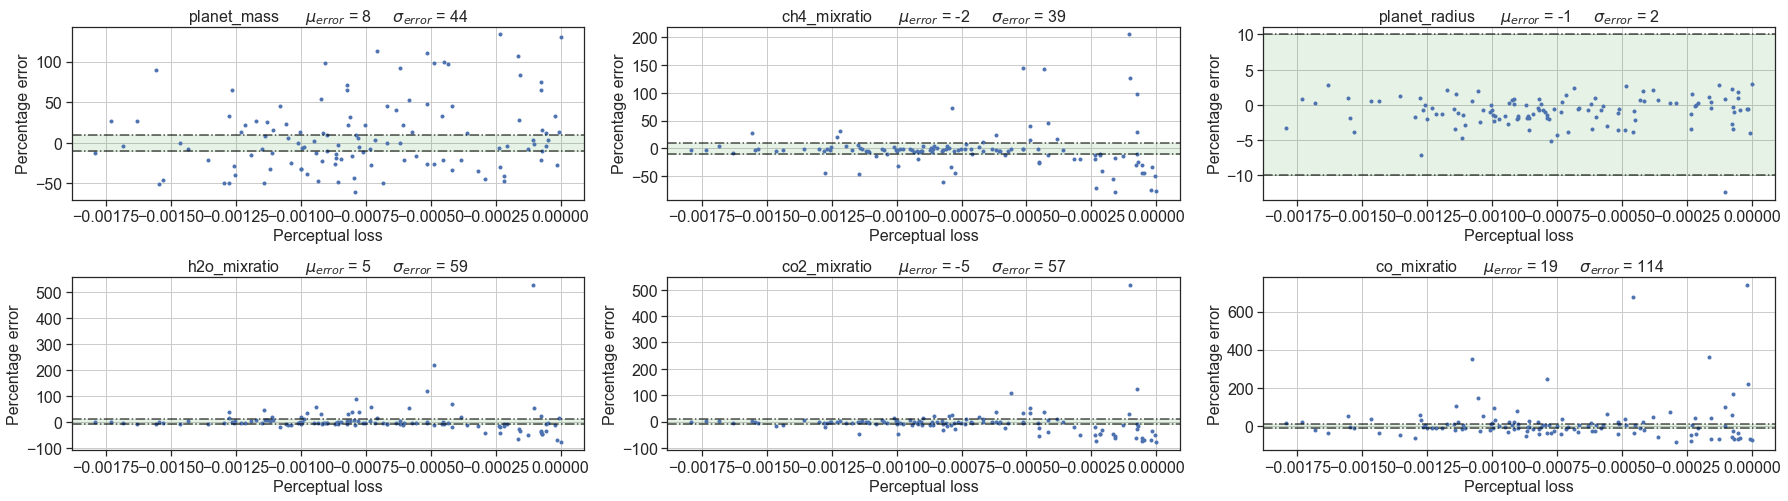

In [446]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f     $\sigma_{error}$ = %.0f' % (param, df[param+'_error'].mean(), df[param+'_error'].std())
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()